In [21]:
from scipy.io import arff
import pandas as pd
import numpy as np

In [22]:
data = arff.loadarff('4year.arff')
df = pd.DataFrame(data[0])

In [23]:
df['bankruptcy'] = (df['class']==b'1')
del df['class']
df.columns = ['X{0:02d}'.format(k) for k in range(1,65)] + ['bankruptcy']

In [24]:
df.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
count,9791.000000,9791.000000,9791.000000,9749.000000,9.771000e+03,9791.000000,9791.000000,9773.000000,9792.000000,9791.000000,...,9.792000e+03,9771.000000,9791.000000,9776.000000,9791.000000,9178.000000,9760.000000,9.771000e+03,9749.000000,9561.000000
mean,0.043019,0.596404,0.130959,8.136600,6.465164e+01,-0.059273,0.059446,19.884016,1.882296,0.389040,...,7.686330e+03,-0.992263,0.035022,1.133287,0.856053,118.156064,25.194430,2.015157e+03,8.660813,35.949619
std,0.359321,4.587122,4.559074,290.647281,1.475939e+04,6.812754,0.533344,698.697015,17.674650,4.590299,...,7.605261e+04,77.007971,8.945365,8.038201,26.393305,3230.316692,1099.260821,1.171461e+05,60.838202,483.318623
min,-12.458000,0.000000,-445.910000,-0.045319,-3.794600e+05,-486.820000,-12.458000,-1.848200,-0.032371,-445.910000,...,-7.132200e+05,-7522.100000,-597.420000,-30.892000,-284.380000,0.000000,-12.656000,-1.496500e+04,-0.024390,-0.000015
25%,0.001321,0.263145,0.020377,1.047000,-5.121700e+01,-0.000578,0.003004,0.428300,1.006675,0.294440,...,2.184000e+01,0.003121,0.008768,0.885722,0.000000,5.356325,4.267700,4.323400e+01,2.938800,2.012900
50%,0.041364,0.467740,0.199290,1.591800,-5.557600e-02,0.000000,0.048820,1.088700,1.161300,0.510450,...,9.503300e+02,0.043679,0.098026,0.958305,0.002129,9.482000,6.283550,7.472900e+01,4.848900,4.041600
75%,0.111130,0.689255,0.410670,2.880400,5.573200e+01,0.065322,0.126940,2.691000,1.970225,0.714290,...,4.694550e+03,0.117170,0.242680,0.996163,0.211790,19.506000,9.938200,1.233450e+02,8.363800,9.413500
max,20.482000,446.910000,22.769000,27146.000000,1.034100e+06,322.200000,38.618000,53209.000000,1704.800000,12.602000,...,6.123700e+06,112.020000,226.760000,668.750000,1661.000000,251570.000000,108000.000000,1.077900e+07,5662.400000,21153.000000


In [25]:
sum(df.bankruptcy == True)

515

In [26]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imp = imp_mean.fit_transform(df.values)

In [27]:
from sklearn.model_selection import train_test_split

X, y = X_imp[:, :-1], X_imp[:, -1]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [28]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=0.01,fit_intercept=True,
 intercept_scaling=1, class_weight=None, random_state=None,solver='liblinear', max_iter=100, multi_class='ovr', verbose=0,warm_start=False,
                        n_jobs=1) # complete
lr.fit(X_train_std,y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
lr.coef_[lr.coef_!=0].shape # check the number of the features with non-zero weights

Training accuracy: 0.9474759264662971
Test accuracy: 0.9469026548672567


(2,)

In [30]:
X_train_std = X_train_std[:, lr.coef_[0]!=0]
X_test_std = X_test_std[:, lr.coef_[0]!=0]
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=0.01, fit_intercept=True,
                        intercept_scaling=1, class_weight=None, random_state=None,solver='liblinear',
                        max_iter=100, multi_class='ovr', verbose=0,warm_start=False,
                            n_jobs=1) 

lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.9474759264662971
Test accuracy: 0.9469026548672567


In [32]:
from sklearn.tree import DecisionTreeClassifier

# selecting features
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree.fit(X_train_std, y_train)

print('Training accuracy:', tree.score(X_train_std, y_train))
print('Test accuracy:', tree.score(X_test_std, y_test))

Training accuracy: 0.948497227896119
Test accuracy: 0.9458815520762424


In [33]:
from sklearn.svm import SVC

svm = SVC(C=100, kernel='linear', gamma=1, decision_function_shape='ovr')
svm.fit(X_train_std, y_train)

print('Training accuracy:', svm.score(X_train_std, y_train))
print('Test accuracy:', svm.score(X_test_std, y_test))

Training accuracy: 0.9474759264662971
Test accuracy: 0.9472430224642614


In [35]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

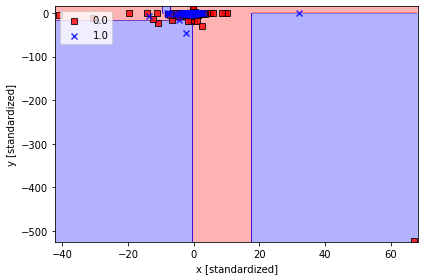

In [36]:
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=tree)
plt.xlabel('x [standardized]')
plt.ylabel('y [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('images/03_11.png', dpi=300)
plt.show()

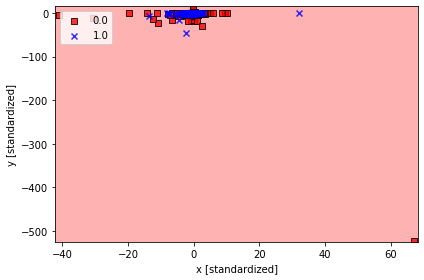

In [38]:
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=svm)
plt.xlabel('x [standardized]')
plt.ylabel('y [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('images/03_11.png', dpi=300)
plt.show()

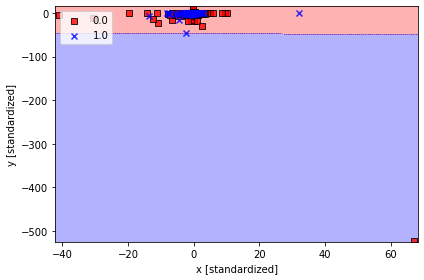

In [37]:
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=lr)
plt.xlabel('x [standardized]')
plt.ylabel('y [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('images/03_11.png', dpi=300)
plt.show()